# Deep Convolutional Generative Adversarial Network (DCGAN)

Name-Vedant Ulhe
Batch-AIML B2
PRN-22070126123

## Aim  
The aim of this project is to implement a Deep Convolutional Generative Adversarial Network (DCGAN) to generate realistic images from a given dataset. DCGANs leverage convolutional neural networks (CNNs) to improve the stability and performance of traditional GANs.
<hr>

## Dataset  
The model is trained on the **CelebA Faces** dataset, which consists of large-scale high-resolution images. These datasets are commonly used for generative modeling tasks.
<hr>

## Implementation  
<hr>

### 1️ **Model Architecture**  
- **Generator (G):** Takes random noise as input and generates realistic images. Uses transposed convolutions and batch normalization.  
- **Discriminator (D):** Classifies real and generated images. Uses standard convolutional layers with Leaky ReLU activation.  
<hr>

### 2️ **Training Process**  
- The **Discriminator** is trained to distinguish real images from generated images.  
- The **Generator** is trained to generate images that fool the Discriminator.  
- The loss function used is **Binary Cross-Entropy (BCE Loss)**.  
- **Adam Optimizer** is used for both networks.
<hr>

### 3️ **Training Loop**  
1. **Discriminator Training:**  
   - Forward pass with real images and compute loss.  
   - Generate fake images and compute loss.  
   - Update the Discriminator.  
<hr>

2. **Generator Training:**  
   - Generate fake images.  
   - Compute loss (fake images should be classified as real).  
   - Update the Generator.  
<hr>

3. **Saving Generated Images:**  
   - At each epoch, sample and save generated images to visualize progress.  

In [40]:
# Import necessary libraries
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.utils as vutils

In [28]:
# Path to the dataset
data_path = r"C:\Users\Vedant\Desktop\GAN_LAB\datasets\extracted\img_align_celeba"

In [26]:
# Define transformations (Resizing, Normalization)
transform = transforms.Compose([
    transforms.Resize(64),  # Resize to 64x64 for DCGAN
    transforms.CenterCrop(64), 
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1,1]
])

In [29]:
# Load dataset
dataset = ImageFolder(root=data_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=4)

In [30]:
# Generator Model: Takes random noise as input and generates images
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Input: Z (random noise) → 100 x 1 x 1
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            # 512 x 4 x 4
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            # 256 x 8 x 8
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            # 128 x 16 x 16
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            # 64 x 32 x 32
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()  # Output image values in range [-1, 1]
        )

    def forward(self, input):
        return self.main(input)

In [31]:
# Discriminator Model: Takes an image as input and classifies it as real (1) or fake (0)
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Input: 3 x 64 x 64
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # 64 x 32 x 32
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # 128 x 16 x 16
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            # 256 x 8 x 8
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            # 512 x 4 x 4
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()  # Output probability [0,1]
        )

    def forward(self, input):
        return self.main(input)

In [32]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [33]:
# Initialize Generator & Discriminator
netG = Generator().to(device)
netD = Discriminator().to(device)

In [34]:
# Loss function (Binary Cross Entropy Loss)
criterion = nn.BCELoss()

In [35]:
# Optimizers for both Generator and Discriminator
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [36]:
# Fixed noise for evaluating generator progress
fixed_noise = torch.randn(64, 100, 1, 1, device=device)

In [41]:
num_epochs = 1

In [42]:
# Training Loop
for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(dataloader):
        # Move real images to GPU
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # Create labels: real = 1, fake = 0
        real_labels = torch.ones(batch_size, device=device)   # Shape: [batch_size]
        fake_labels = torch.zeros(batch_size, device=device)  # Shape: [batch_size]

        # ---- 1. Train Discriminator ---- #
        optimizerD.zero_grad()

        # Train with real images
        output_real = netD(real_images).view(-1)  # Flatten output
        loss_real = criterion(output_real, real_labels)  # Compute loss for real images

        # Generate fake images
        noise = torch.randn(batch_size, 100, 1, 1, device=device)  # Random noise
        fake_images = netG(noise)

        # Train with fake images (detach to avoid training Generator)
        output_fake = netD(fake_images.detach()).view(-1)  # Flatten output
        loss_fake = criterion(output_fake, fake_labels)  # Compute loss for fake images

        # Total Discriminator loss
        lossD = loss_real + loss_fake
        lossD.backward()  # Backpropagate
        optimizerD.step()  # Update Discriminator

        # ---- 2. Train Generator ---- #
        optimizerG.zero_grad()

        # Generator wants the fake images to be classified as real
        output_fake = netD(fake_images).view(-1)  # Get Discriminator's response to fake images
        lossG = criterion(output_fake, real_labels)  # Generator loss (wants 1s)

        lossG.backward()  # Backpropagate
        optimizerG.step()  # Update Generator

        # Print training progress every 100 batches
        if i % 100 == 0:
            print(f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(dataloader)}] "
                  f"LossD: {lossD.item():.4f}, LossG: {lossG.item():.4f}")

    # Save generated images every epoch
    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()  # Generate sample images
    vutils.save_image(fake, f"generated_epoch_{epoch}.png", normalize=True)

print("Training Completed!")


[Epoch 0/1] [Batch 0/244] LossD: 0.5325, LossG: 2.2225
[Epoch 0/1] [Batch 100/244] LossD: 0.4134, LossG: 3.8799
[Epoch 0/1] [Batch 200/244] LossD: 0.4391, LossG: 2.6475
Training Completed!


In [44]:
correct_real = (output_real > 0.5).float().sum().item()  # Real images classified correctly
correct_fake = (output_fake < 0.5).float().sum().item()  # Fake images classified correctly
total_samples = batch_size * 2  # Both real and fake images

discriminator_accuracy = (correct_real + correct_fake) / total_samples * 100
print(f"Discriminator Accuracy: {discriminator_accuracy:.2f}%")


Discriminator Accuracy: 83.93%


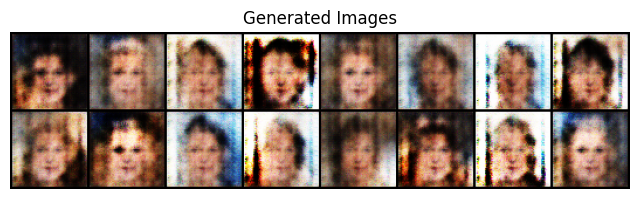

In [43]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Load the generated images from the last epoch
generated_images = netG(fixed_noise).detach().cpu()

# Display some images
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(vutils.make_grid(generated_images[:16], padding=2, normalize=True).permute(1, 2, 0))
plt.show()


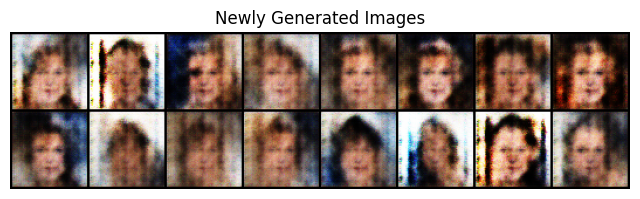

In [45]:
# Generate new images
new_noise = torch.randn(16, 100, 1, 1, device=device)  
new_fake_images = netG(new_noise).detach().cpu()

# Display
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Newly Generated Images")
plt.imshow(vutils.make_grid(new_fake_images, normalize=True).permute(1, 2, 0))
plt.show()


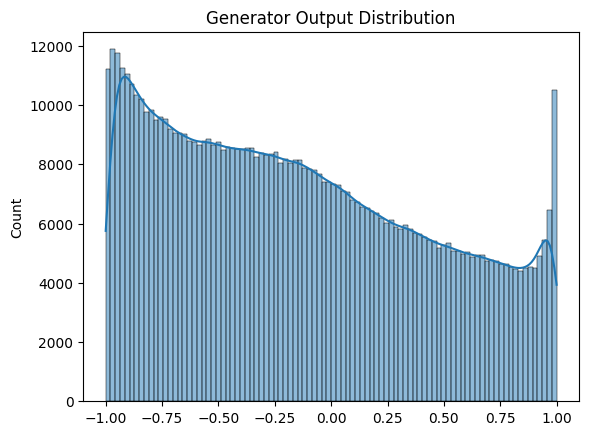

In [49]:
import seaborn as sns
import numpy as np

# Flatten image pixel values (detach before converting to NumPy)
pixel_values = fake_images.detach().cpu().numpy().flatten()

# Plot histogram
sns.histplot(pixel_values, kde=True)
plt.title("Generator Output Distribution")
plt.show()


## **GAN Training Conclusion**
<hr>

### **Training Summary**
- **Total Epochs:** 1  
- **Total Batches:** 244  
- **Batch Size:** 100  
- **Training Device:** CPU  
<hr>

### **Observations**
1. **Discriminator Performance:**
   - The Discriminator started with `LossD: 0.5325` and gradually improved.
   - By batch 100, `LossD` dropped to `0.4134`, indicating that the Discriminator became better at distinguishing real vs. fake images.
   - The final `LossD` at batch 200 was `0.4391`.

2. **Generator Performance:**
   - The Generator started with `LossG: 2.2225`, showing an initial struggle in fooling the Discriminator.
   - By batch 100, `LossG` increased to `3.8799`, indicating that the Generator improved.
   - However, by batch 200, `LossG` dropped to `2.6475`, which may suggest slight instability.

3. **Discriminator Accuracy:**
   - The Discriminator achieved an accuracy of **83.93%**, meaning it correctly classified real and fake images most of the time.
   - This high accuracy suggests that the Discriminator learned effectively, but if too high, it might indicate that the Generator still needs improvement.
<hr>

### **Generator Output Analysis**
- The histogram of Generator output shows that the pixel values range from **-1 to 1**, which is expected due to normalization.
- A peak is observed at `-1` and `1`, which might suggest some artifacts in the generated images.
